## Detect Bias with SageMaker Clarify 
haimtran 09/06/2023

- [Estimator SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)
- [XGBoost Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)
- [CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrainingJob.html)
- [Training Storage Folder](https://docs.aws.amazon.com/sagemaker/latest/dg/model-train-storage.html)
- [API Low Level](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_parquet_input_training.html#Training-with-sagemaker-training)
- [Provide Training Information](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo-running-container.html)
- [Validation Path Examnple](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.html)

{"train_channel": train_input} ==> /opt/ml/input/data/train_channel/

In [141]:
import os

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sagemaker

## SageMaker Session 

In [142]:
role = sagemaker.get_execution_role()

In [143]:
session = sagemaker.session.Session()

In [144]:
bucket = session.default_bucket()

In [145]:
region = session.boto_region_name

## Download Data From S3 

In [146]:
from sagemaker.s3 import S3Downloader

In [147]:
adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]

In [148]:
S3Downloader.download(
    s3_uri=f"s3://sagemaker-example-files-prod-{region}/datasets/tabular/uci_adult/adult.data",
    local_path="./",
    sagemaker_session=session,
)

In [149]:
S3Downloader.download(
    s3_uri=f"s3://sagemaker-example-files-prod-{region}/datasets/tabular/uci_adult/adult.test",
    local_path="./",
    sagemaker_session=session,
)

In [150]:
training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

In [151]:
testing_data = pd.read_csv(
    "adult.test",
    names=adult_columns,
    sep=r"\s*,\s*",
    engine="python",
    na_values="?",
    skiprows=1,
).dropna()

In [152]:
training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [153]:
testing_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


## Data Visualization 

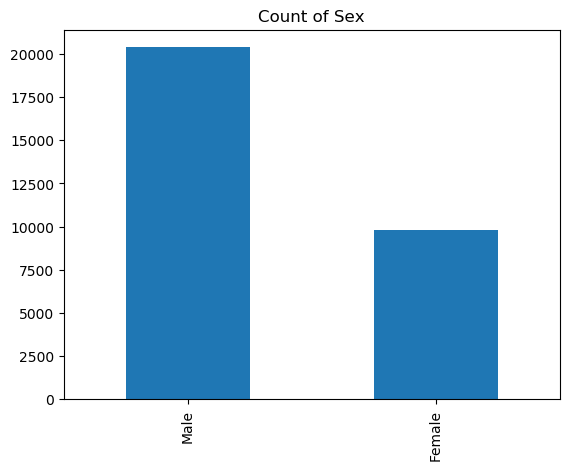

In [154]:
training_data["Sex"].value_counts().plot.bar()
plt.title("Count of Sex")
plt.show()

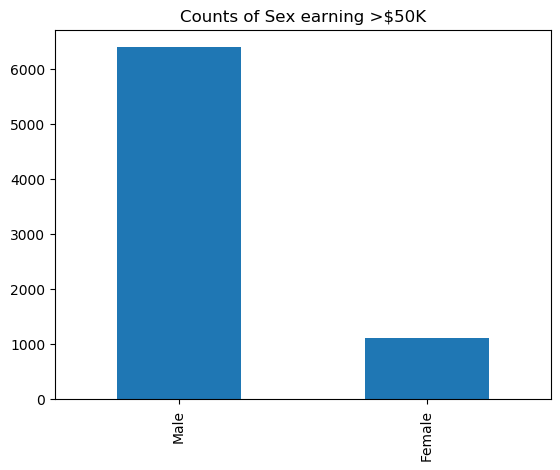

In [155]:
training_data["Sex"].where(training_data["Target"] == ">50K").value_counts().plot.bar()
plt.title("Counts of Sex earning >$50K")
plt.show()

## Prepare Data For Training 

In [156]:
from sklearn import preprocessing

In [157]:
def number_encode_features(df: pd.DataFrame):
    """
    convert categorical to numerical
    """
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(
                result[column].fillna("None")
            )

    return result, encoders

In [158]:
training_data = pd.concat(
    [training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1
)

In [159]:
testing_data = pd.concat(
    [testing_data["Target"], testing_data.drop(["Target"], axis=1)], axis=1
)

In [160]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,<=50K,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,<=50K,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,<=50K,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,<=50K,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,<=50K,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [161]:
testing_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,<=50K.,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,<=50K.,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,>50K.,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,>50K.,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
5,<=50K.,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States


In [162]:
training_data, _ = number_encode_features(training_data)

In [163]:
testing_data, _ = number_encode_features(testing_data)

In [164]:
training_data.to_csv("train_data.csv", index=False, header=False)

In [165]:
testing_data.to_csv("test_features.csv", index=False, header=False)

In [166]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [167]:
testing_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,25,2,226802,1,7,4,6,3,2,1,0,0,40,37
1,0,38,2,89814,11,9,2,4,0,4,1,0,0,50,37
2,1,28,1,336951,7,12,2,10,0,4,1,0,0,40,37
3,1,44,2,160323,15,10,2,6,0,2,1,7688,0,40,37
5,0,34,2,198693,0,6,4,7,1,4,1,0,0,30,37


## Upload Preprocessed Data to S3 for Training 

In [168]:
from sagemaker.inputs import TrainingInput
from sagemaker.s3 import S3Uploader

In [169]:
prefix = "sagemaker-clarify"

In [170]:
train_uri = S3Uploader.upload(
    local_path="./train_data.csv", desired_s3_uri=f"s3://{bucket}/{prefix}"
)

In [171]:
test_uri = S3Uploader.upload(
    local_path="./test_features.csv", desired_s3_uri=f"s3://{bucket}/{prefix}"
)

In [179]:
train_uri

's3://sagemaker-ap-southeast-1-140149423990/sagemaker-clarify/train_data.csv'

In [180]:
train_input = TrainingInput(train_uri, content_type="csv")

In [181]:
!aws s3 ls s3://{bucket}/{prefix}/

2023-06-17 03:25:04    3974305 adult.data
2023-06-17 03:40:11     596475 test_features.csv
2023-06-17 03:40:11    1194921 train_data.csv


In [182]:
train_input

## Train XGBoost Model 

- [Estimator SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)
- [XGBoost Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)
- [CreateTrainingJob API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrainingJob.html)
- [Training Storage Folder](https://docs.aws.amazon.com/sagemaker/latest/dg/model-train-storage.html)
- [API Low Level](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_parquet_input_training.html#Training-with-sagemaker-training)
- [Provide Training Information](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo-running-container.html)
- [Validation Path Examnple](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.html)

{"train_channel": train_input} ==> /opt/ml/input/data/train_channel/

In [173]:
from sagemaker.estimator import Estimator
from sagemaker.image_uris import retrieve

In [174]:
xgboost_image_uri = retrieve("xgboost", region, version="1.5-1")

In [175]:
xgboost_image_uri

'121021644041.dkr.ecr.ap-southeast-1.amazonaws.com/sagemaker-xgboost:1.5-1'

In [176]:
xgb = Estimator(
    xgboost_image_uri,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

In [177]:
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

In [178]:
!aws s3 ls s3://{bucket}/{prefix}/

2023-06-17 03:25:04    3974305 adult.data
2023-06-17 03:40:11     596475 test_features.csv
2023-06-17 03:40:11    1194921 train_data.csv


In [183]:
xgb.fit({"train": train_input}, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-06-17-03-43-41-219



2023-06-17 03:43:41 Starting - Starting the training job..
2023-06-17 03:43:56 Starting - Preparing the instances for training........
2023-06-17 03:44:44 Downloading - Downloading input data....
2023-06-17 03:45:09 Training - Downloading the training image....
2023-06-17 03:45:35 Training - Training image download completed. Training in progress.......
2023-06-17 03:46:10 Uploading - Uploading generated training model.
2023-06-17 03:46:21 Completed - Training job completed


## Create a Model

- Option 1. use model = estimator.create_modele() then model.create()
- Option 2. sagemaker_client.create_model()
- Option 3. sagemaker_session.create_model()

```py
model_name = "DEMO-clarify-model-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
sagemaker_session.create_model(model_name, role, container_def)
```

In [185]:
from datetime import datetime

In [197]:
model_name = f"demo-clarify-bias-{datetime.now().strftime('%d-%m-%Y-%H-%M-%S')}"

In [198]:
model = xgb.create_model(name=model_name)

In [199]:
container_def = model.prepare_container_def()

In [202]:
model.image_uri

'121021644041.dkr.ecr.ap-southeast-1.amazonaws.com/sagemaker-xgboost:1.5-1'

In [203]:
model.prepare_container_def()

{'Image': '121021644041.dkr.ecr.ap-southeast-1.amazonaws.com/sagemaker-xgboost:1.5-1',
 'Environment': {},
 'ModelDataUrl': 's3://sagemaker-ap-southeast-1-140149423990/sagemaker-xgboost-2023-06-17-03-43-41-219/output/model.tar.gz'}

In [204]:
model.role

'arn:aws:iam::140149423990:role/RoleForDataScientistUserProfile'

In [205]:
model.create()

INFO:sagemaker:Creating model with name: demo-clarify-bias-17-06-2023-04-10-24


## Amazon SageMaker Clarify 

In [217]:
from sagemaker import clarify

In [218]:
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### DataConfig

In [219]:
!aws s3 ls s3://{bucket}/sagemaker-clarify/

2023-06-17 03:25:04    3974305 adult.data
2023-06-17 03:40:11     596475 test_features.csv
2023-06-17 03:40:11    1194921 train_data.csv


In [226]:
bias_report_output_path = f"s3://{bucket}/clarify-bias"

In [227]:
data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

### Model Config

In [228]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

### Bias Config 

In [229]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1],
    facet_name="Sex",
    facet_values_or_threshold=[0],
    group_name="Age",
)

### Model Predicted Labels Config

In [230]:
prediction_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

### Runt the Clarify Job

In [231]:
clarify_processor.run_bias(
    data_config=data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=prediction_config,
    pre_training_methods="all",
    post_training_methods="all"
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['Target', 'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country'], 'label': 'Target', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'Sex', 'value_or_threshold': [0]}], 'group_variable': 'Age', 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}, 'post_training_bias': {'methods': 'all'}}, 'predictor': {'model_name': 'demo-clarify-bias-17-06-2023-04-10-24', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}, 'probability_threshold': 0.8}
INFO:sagemaker:Creating processing-job with name Clarify-Bias-2023-06-17-04-37-49-633


............................2023-06-17 04:42:30,413 logging.conf not found when configuring logging, using default logging configuration.
2023-06-17 04:42:30,414 Starting SageMaker Clarify Processing job
2023-06-17 04:42:30,414 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2023-06-17 04:42:30,414 Analysis result path: /opt/ml/processing/output
2023-06-17 04:42:30,414 This host is algo-1.
2023-06-17 04:42:30,414 This host is the leader.
2023-06-17 04:42:30,414 Number of hosts in the cluster is 1.
Error retrieving tags. resource_arn: arn:aws:sagemaker:ap-southeast-1:140149423990:processing-job/clarify-bias-2023-06-17-04-37-49-633
2023-06-17 04:42:30,672 Failed to fetch tags for ProcessingJobArn: arn:aws:sagemaker:ap-southeast-1:140149423990:processing-job/clarify-bias-2023-06-17-04-37-49-633
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/analyzer/data_loading/data_loader_util.py", line 143, in load_configs
    tags = sagemak